Fetching data for 50 tickers from 2016-01-01 to 2025-09-23...


/tmp/ipython-input-2738644536.py:52: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(nifty50_tickers, start=full_start, end=full_end, progress=False)["Close"]
ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: TATAMOTORS.NS"}}}
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TATAMOTORS.NS']: YFTzMissingError('possibly delisted; no timezone found')


Using 49 tickers present across train, validation, and test periods.

--- STAGE 1: Finding pairs in training data (2016-01-01 to 2022-12-31) ---
Found 116 cointegrated relationships in training data.

--- STAGE 2: Validating pairs on data from 2023-01-01 to 2023-12-31 (Filter > 7.0% total return AND Sharpe >= 1.0) ---


/tmp/ipython-input-2738644536.py:153: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  S1_prev = S1.shift(1).replace(0, np.nan).fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-2738644536.py:154: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  S2_prev = S2.shift(1).replace(0, np.nan).fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-2738644536.py:153: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  S1_prev = S1.shift(1).replace(0, np.nan).fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-2738644536.py:154: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  S2_prev = S2.shift(1).replace(0, np.nan).fillna

Saved performance of 116 pairs on validation data to validation_results_return_sharpe_weighted_stop.csv
Validated 34 pairs with total return > 7.0% and Sharpe >= 1.0 to carry forward.

--- STAGE 3: Daily Rolling Parameter Test (WITH STOP-LOSS) from 2024-01-01 to 2025-09-23 ---
Total Portfolio Weight Allocated (after normalization): 1.0000

-------------------------------------------------------------
FINAL COMBINED PORTFOLIO (DAILY ROLLING, WITH STOP) annual return = 7.74%
FINAL COMBINED PORTFOLIO Sharpe Ratio = 0.96
-------------------------------------------------------------



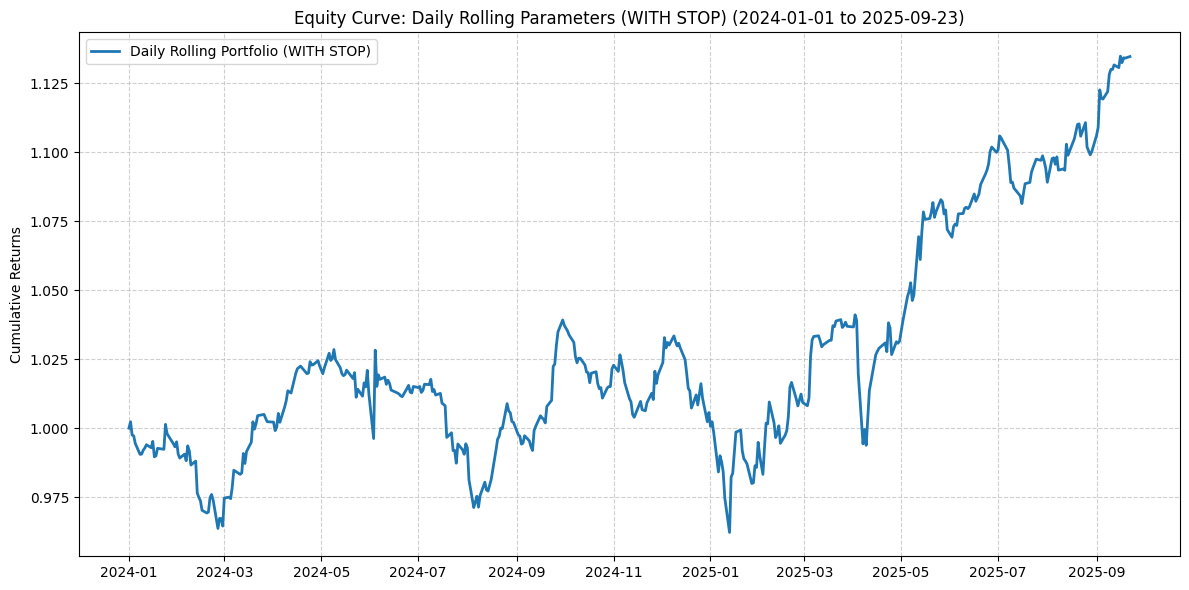

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
from itertools import combinations
from datetime import datetime

# =================================================================
# 1. SETTINGS / DATES (with Robustness Upgrades)
# =================================================================
nifty50_tickers = [
    "RELIANCE.NS","HDFCBANK.NS","ICICIBANK.NS","INFY.NS","TCS.NS","KOTAKBANK.NS","LT.NS","AXISBANK.NS",
    "HINDUNILVR.NS","SBIN.NS","BHARTIARTL.NS","ITC.NS","ASIANPAINT.NS","BAJFINANCE.NS","HCLTECH.NS",
    "MARUTI.NS","WIPRO.NS","ULTRACEMCO.NS","ONGC.NS","NTPC.NS","SUNPHARMA.NS","POWERGRID.NS","BAJAJFINSV.NS",
    "TECHM.NS","NESTLEIND.NS","TITAN.NS","ADANIPORTS.NS","CIPLA.NS","INDUSINDBK.NS","TATAMOTORS.NS",
    "JSWSTEEL.NS","COALINDIA.NS","SHREECEM.NS","BPCL.NS","HINDALCO.NS","HEROMOTOCO.NS","BRITANNIA.NS",
    "DRREDDY.NS","EICHERMOT.NS","GRASIM.NS","SBILIFE.NS","DIVISLAB.NS","TATASTEEL.NS","UPL.NS","BAJAJ-AUTO.NS",
    "IOC.NS","M&M.NS","HDFCLIFE.NS","ADANIENT.NS","APOLLOHOSP.NS"
]

full_start = "2016-01-01"
full_end = "2025-09-23"
train_start = "2016-01-01"
train_end = "2022-12-31"
validation_start = "2023-01-01"
validation_end = "2023-12-31"
test_start = "2024-01-01"
test_end = full_end

# Filters / thresholds
MIN_OBS = 500             # minimum common observations in train
PVAL_THRESHOLD = 0.05     # cointegration p-value threshold (train)
HALFLIFE_MIN = 5          # min half-life days
HALFLIFE_MAX = 120        # max half-life days
ENTRY_MULT = 1.5          # entry threshold multiplier of sigma_eq
EXIT_MULT  = 0.25         # exit threshold multiplier

# 🚨 ROBUSTNESS ADDITIONS
STOP_MULT = 3.0           # Stop-loss at 3.0 standard deviations
STOP_DAYS = 3             # Must stay above stop for 3 consecutive days to trigger stop-loss (only used in fixed backtest)
MIN_SHARPE_VALIDATION = 1.0 # Minimum Sharpe ratio required for validation success

VALIDATION_THRESHOLD_RETURN = 7.0 # total return % over validation
RISK_FREE_RATE_ANNUAL = 0.0 # annual risk-free rate for Sharpe

# =================================================================
# 2. DATA FETCHING AND PREPARATION
# =================================================================
print(f"Fetching data for {len(nifty50_tickers)} tickers from {full_start} to {full_end}...")
prices = yf.download(nifty50_tickers, start=full_start, end=full_end, progress=False)["Close"]
prices = prices.dropna(axis=1, thresh=len(prices)*0.75)  # require 75% coverage globally
prices = prices.sort_index()

prices_train = prices.loc[train_start:train_end]
prices_validation = prices.loc[validation_start:validation_end]
prices_test = prices.loc[test_start:test_end]

# Find common tickers across all three periods
common_train_val = set(prices_train.columns).intersection(prices_validation.columns)
common_tickers = sorted(list(common_train_val.intersection(prices_test.columns)))

prices_train = prices_train[common_tickers].dropna(how='all', axis=1)
prices_validation = prices_validation[common_tickers].dropna(how='all', axis=1)
prices_test = prices_test[common_tickers].dropna(how='all', axis=1)

print(f"Using {len(common_tickers)} tickers present across train, validation, and test periods.")

# Combine Training and Validation data for the baseline of the rolling window
prices_train_val = pd.concat([prices_train, prices_validation]).sort_index()
prices_test_only = prices.loc[test_start:test_end] # Use full price object for rolling

# =================================================================
# 3. HELPER FUNCTIONS
# =================================================================

def fit_ou(spread):
    spread_lag = spread.shift(1).dropna()
    spread_ret = spread.diff().dropna()
    spread_lag = spread_lag.loc[spread_ret.index]
    X = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret, X).fit()
    if 'const' not in model.params or len(model.params) < 2:
        return None, None, None
    a = model.params['const']
    b = model.params.iloc[1]

    # require mean reversion in discrete sense
    if b >= 0 or 1 + b <= 0:
        return None, None, None

    theta = -np.log1p(b)
    mu = a / (-b)
    sigma = np.std(model.resid, ddof=1)
    return mu, theta, sigma

def compute_half_life(theta):
    if theta is None or theta <= 0:
        return np.inf
    return np.log(2) / theta

def calculate_sharpe(daily_returns, risk_free_rate_annual=RISK_FREE_RATE_ANNUAL):
    """Annualized Sharpe using daily returns."""
    if daily_returns is None or len(daily_returns) == 0:
        return 0.0
    rf_daily = risk_free_rate_annual / 252.0
    excess = daily_returns - rf_daily
    std = excess.std(ddof=1)
    if std == 0 or np.isnan(std):
        return 0.0
    return np.sqrt(252.0) * (excess.mean() / std)

def simulate_backtest(S1, S2, hedge_ratio, mu_train, theta_train, sigma_train,
                      entry_mult=ENTRY_MULT, exit_mult=EXIT_MULT, tc_per_side=0.0005,
                      notional_per_side=1.0, stop_mult=STOP_MULT, stop_days=STOP_DAYS, max_loss_pct=None):
    """Pairs backtest using fixed parameters for the whole period (used for Validation)."""
    spread = S1 - hedge_ratio * S2
    if theta_train is None or theta_train <= 0:
        return None, None, None, None, 0

    sigma_eq = sigma_train / np.sqrt(2 * theta_train)
    entry_th = entry_mult * sigma_eq
    exit_th  = exit_mult * sigma_eq
    stop_th = stop_mult * sigma_eq if stop_mult is not None else None

    dates = spread.index
    n = len(dates)
    signal = pd.Series(0, index=dates, dtype=int)

    # generate signal with optional persistence stop
    consec_over_stop = 0
    for i in range(1, n):
        dev = spread.iloc[i] - mu_train
        prev = signal.iloc[i-1]

        # 🚨 STOP-LOSS LOGIC REMOVED FOR VALIDATION (Only entry/exit remains)
        # Normal entry/exit logic
        if prev == 0:
            if dev < -entry_th:
                signal.iloc[i] = 1
            elif dev > entry_th:
                signal.iloc[i] = -1
            else:
                signal.iloc[i] = 0
        else:
            if abs(dev) < exit_th:
                signal.iloc[i] = 0
            else:
                signal.iloc[i] = prev

    pos = signal.shift(1).fillna(0).astype(int)
    S1_prev = S1.shift(1).replace(0, np.nan).fillna(method='ffill').fillna(method='bfill')
    S2_prev = S2.shift(1).replace(0, np.nan).fillna(method='ffill').fillna(method='bfill')

    qty1 = notional_per_side / S1_prev
    qty2 = (notional_per_side * abs(hedge_ratio)) / S2_prev

    qty1_signed = pos * qty1
    qty2_signed = -pos * np.sign(hedge_ratio) * qty2

    pnl_usd = qty1_signed * (S1 - S1_prev) + qty2_signed * (S2 - S2_prev)
    notional = (qty1.abs() * S1_prev) + (qty2.abs() * S2_prev)
    notional = notional.replace(0, np.nan)
    trades = (pos != pos.shift(1)).astype(int)
    tc_usd = trades * ( (qty1.abs() * S1_prev + qty2.abs() * S2_prev) * 0.0005 ) # Use tc_per_side=0.0005
    daily_ret = (pnl_usd - tc_usd) / notional
    daily_ret = daily_ret.fillna(0)

    cum = (1 + daily_ret).cumprod()
    n_trades = int(trades.sum())
    T = len(daily_ret)
    if T <= 1:
        return None, None, None, None, n_trades

    annual_ret = (cum.iloc[-1] ** (252.0 / T) - 1) * 100.0
    active_mask = notional.fillna(0) > 0
    sharpe = calculate_sharpe(daily_ret[active_mask], risk_free_rate_annual=RISK_FREE_RATE_ANNUAL) if active_mask.any() else 0.0

    return annual_ret, cum, daily_ret, sharpe, n_trades

def calculate_rolling_params(s1_full_history, s2_full_history):

    # Run OLS for hedge ratio
    ols = sm.OLS(s1_full_history, sm.add_constant(s2_full_history)).fit()
    hedge = ols.params.iloc[1]

    # Calculate spread
    spread = s1_full_history - hedge * s2_full_history

    # Fit OU model to the spread
    mu, theta, sigma = fit_ou(spread)

    if mu is None:
        return None, None, None, None, np.inf

    halflife = compute_half_life(theta)

    # Filter by half-life (optional in rolling, but kept for consistency)
    if not (HALFLIFE_MIN <= halflife <= HALFLIFE_MAX):
        return None, None, None, None, halflife

    sigma_eq = sigma / np.sqrt(2 * theta)

    # Return all necessary parameters and derived thresholds
    return hedge, mu, sigma_eq, sigma, halflife

# =================================================================
# 4. STAGE 1: Find cointegrated pairs (TRAIN period)
# =================================================================
coint_pairs = []
print(f"\n--- STAGE 1: Finding pairs in training data ({train_start} to {train_end}) ---")
for s1_name, s2_name in combinations(common_tickers, 2):
    s1_series = prices_train[s1_name].dropna()
    s2_series = prices_train[s2_name].dropna()

    idx = s1_series.index.intersection(s2_series.index)
    if len(idx) < MIN_OBS:
        continue

    s1_al, s2_al = s1_series.loc[idx], s2_series.loc[idx]

    # Test 1: s1 onto s2
    _, pval1, _ = coint(s1_al, s2_al)
    if pval1 < PVAL_THRESHOLD:
        ols1 = sm.OLS(s1_al, sm.add_constant(s2_al)).fit()
        hedge1 = ols1.params.iloc[1]
        spread1 = s1_al - hedge1 * s2_al
        mu1, theta1, sigma1 = fit_ou(spread1)
        if mu1 is not None:
            halflife1 = compute_half_life(theta1)
            if HALFLIFE_MIN <= halflife1 <= HALFLIFE_MAX:
                coint_pairs.append({
                    "s1": s1_name, "s2": s2_name, "pval": pval1, "hedge": hedge1,
                    "mu_train": mu1, "theta_train": theta1, "sigma_train": sigma1,
                    "halflife": halflife1
                })

    # Test 2: s2 onto s1
    _, pval2, _ = coint(s2_al, s1_al)
    if pval2 < PVAL_THRESHOLD:
        ols2 = sm.OLS(s2_al, sm.add_constant(s1_al)).fit()
        hedge2 = ols2.params.iloc[1]
        spread2 = s2_al - hedge2 * s1_al
        mu2, theta2, sigma2 = fit_ou(spread2)
        if mu2 is not None:
            halflife2 = compute_half_life(theta2)
            if HALFLIFE_MIN <= halflife2 <= HALFLIFE_MAX:
                coint_pairs.append({
                    "s1": s2_name, "s2": s1_name, "pval": pval2, "hedge": hedge2,
                    "mu_train": mu2, "theta_train": theta2, "sigma_train": sigma2,
                    "halflife": halflife2
                })

print(f"Found {len(coint_pairs)} cointegrated relationships in training data.")

# =================================================================
# 5. STAGE 2: Validate pairs (VALIDATION period with Sharpe Filter)
# =================================================================
validation_results = []
validated_profitable_pairs = []

print(f"\n--- STAGE 2: Validating pairs on data from {validation_start} to {validation_end} (Filter > {VALIDATION_THRESHOLD_RETURN}% total return AND Sharpe >= {MIN_SHARPE_VALIDATION}) ---")
for pair in coint_pairs:
    s1, s2 = pair["s1"], pair["s2"]
    if s1 not in prices_validation.columns or s2 not in prices_validation.columns:
        continue

    s1_val, s2_val = prices_validation[s1].dropna(), prices_validation[s2].dropna()
    idx_val = s1_val.index.intersection(s2_val.index)
    if len(idx_val) < 30:
        continue

    backtest_params = {
        'hedge_ratio': pair['hedge'], 'mu_train': pair['mu_train'],
        'theta_train': pair['theta_train'], 'sigma_train': pair['sigma_train'],
        'stop_mult': STOP_MULT, 'stop_days': STOP_DAYS
    }

    annual_ret, cum, daily_ret, sharpe_ratio, n_trades = simulate_backtest(
        s1_val.loc[idx_val], s2_val.loc[idx_val], **backtest_params)

    if annual_ret is not None:
        total_ret_pct = (cum.iloc[-1] - 1.0) * 100.0
        validation_results.append({**pair, "annual_ret_validation": annual_ret, "total_ret_pct_validation": total_ret_pct, "sharpe_validation": sharpe_ratio, "n_trades_validation": n_trades})

        # Apply both return and Sharpe filters
        if total_ret_pct > VALIDATION_THRESHOLD_RETURN and sharpe_ratio >= MIN_SHARPE_VALIDATION:
            pair_copy = pair.copy()
            pair_copy['validation_return_pct'] = total_ret_pct
            validated_profitable_pairs.append(pair_copy)

# Save validation results to CSV
out_df_val = pd.DataFrame(validation_results).drop(columns=['mu_train', 'theta_train', 'sigma_train'], errors='ignore')
out_df_val.to_csv("validation_results_return_sharpe_weighted_stop.csv", index=False)
print(f"Saved performance of {len(out_df_val)} pairs on validation data to validation_results_return_sharpe_weighted_stop.csv")
print(f"Validated {len(validated_profitable_pairs)} pairs with total return > {VALIDATION_THRESHOLD_RETURN}% and Sharpe >= {MIN_SHARPE_VALIDATION} to carry forward.")

# =================================================================
# 6. STAGE 3: DAILY ROLLING PARAMETER CALCULATION AND TEST (WITH STOP-LOSS)
# =================================================================
final_results = []
# Create a data structure to hold daily returns for each pair
all_daily_returns_test = pd.DataFrame(index=prices_test_only.index)
test_dates = prices_test_only.index

print(f"\n--- STAGE 3: Daily Rolling Parameter Test (WITH STOP-LOSS) from {test_start} to {test_end} ---")
if not validated_profitable_pairs:
    print("No profitable and robust pairs found in validation period. Exiting.")
else:
    # Step 1: Prepare weights (based on validation returns, as before)
    returns_list = [pair['validation_return_pct'] for pair in validated_profitable_pairs]
    positive_returns = [r for r in returns_list if r > 0]
    total_positive_returns = sum(positive_returns)

    if total_positive_returns > 0:
        weights_raw = [ (r / total_positive_returns) if r > 0 else 0.0 for r in returns_list ]
    else:
        weights_raw = [1.0 / len(validated_profitable_pairs)] * len(validated_profitable_pairs)

    weight_sum = sum(weights_raw)
    weights = [w / weight_sum if weight_sum > 0 else 1.0/len(weights_raw) for w in weights_raw]

    # FIX: Initialize 'notional_per_side' for every pair here
    for i, pair in enumerate(validated_profitable_pairs):
        pair['weight'] = weights[i]
        pair['notional_per_side'] = 1.0

    print(f"Total Portfolio Weight Allocated (after normalization): {sum(weights):.4f}")

    # Step 2: Daily Walk-Forward Backtest

    # Initialize position and performance tracking for each pair
    pair_positions = {f"{p['s1']}-{p['s2']}": 0 for p in validated_profitable_pairs}
    pair_trades = {f"{p['s1']}-{p['s2']}": 0 for p in validated_profitable_pairs}

    # Loop starts from the second test day (T) to calculate parameters using data up to T-1
    for i in range(1, len(test_dates)):
        current_date = test_dates[i]
        prev_date = test_dates[i-1]

        # Data history includes Train + Validation + Test data up to T-1
        data_history = prices.loc[train_start:prev_date]

        daily_portfolio_return = 0.0
        active_pairs = 0

        for pair in validated_profitable_pairs:
            s1, s2 = pair["s1"], pair["s2"]
            pair_key = f"{s1}-{s2}"
            weight = pair['weight']

            s1_hist = data_history.get(s1).dropna()
            s2_hist = data_history.get(s2).dropna()

            if len(s1_hist) < MIN_OBS or len(s2_hist) < MIN_OBS:
                continue

            # Ensure latest prices are available
            if current_date not in prices_test_only.index or prev_date not in prices_test_only.index:
                 continue

            S1_t = prices_test_only.loc[current_date, s1]
            S2_t = prices_test_only.loc[current_date, s2]
            S1_t_prev = prices_test_only.loc[prev_date, s1]
            S2_t_prev = prices_test_only.loc[prev_date, s2]

            if np.isnan(S1_t) or np.isnan(S2_t) or np.isnan(S1_t_prev) or np.isnan(S2_t_prev):
                continue

            # 1. Calculate Rolling Parameters (Hedge, Mu, Sigma_eq) up to T-1
            hedge, mu, sigma_eq, sigma, halflife = calculate_rolling_params(s1_hist, s2_hist)

            if mu is None:
                # If cointegration or mean-reversion is broken, force flat position
                pair_positions[pair_key] = 0
                continue

            # 2. Trading Signal Generation (Based on T-1 spread deviation)
            current_spread_dev = S1_t_prev - hedge * S2_t_prev - mu

            entry_th = ENTRY_MULT * sigma_eq
            exit_th = EXIT_MULT * sigma_eq
            stop_th = STOP_MULT * sigma_eq # 🚨 STOP THRESHOLD RECALCULATED DAILY

            prev_pos = pair_positions[pair_key]
            current_pos = prev_pos

            # 🚨 STOP-LOSS LOGIC RE-INTEGRATED
            if prev_pos != 0 and abs(current_spread_dev) > stop_th:
                # Force flat immediately if breaching 3 sigma (Stop-Loss)
                current_pos = 0
            else:
                # Normal Entry/Exit logic
                if prev_pos == 0:
                    if current_spread_dev < -entry_th:
                        current_pos = 1 # Long Spread
                    elif current_spread_dev > entry_th:
                        current_pos = -1 # Short Spread
                else:
                    if abs(current_spread_dev) < exit_th:
                        current_pos = 0 # Exit

            # 3. PnL Calculation and Daily Return
            pos = current_pos # This position is held from T to T+1 (i.e., executed at T)

            if pos != 0:
                active_pairs += 1

                # Qty is based on T-1 prices (for execution at T)
                qty1 = pair['notional_per_side'] / S1_t_prev
                qty2 = (pair['notional_per_side'] * abs(hedge)) / S2_t_prev

                # PnL from T-1 to T
                pnl_usd = (pos * qty1 * (S1_t - S1_t_prev)) + \
                          (-pos * np.sign(hedge) * qty2 * (S2_t - S2_t_prev))

                # Transaction Cost (if position changed)
                if pos != prev_pos:
                    # Use fixed transaction cost (0.0005 per side)
                    tc_usd = (qty1 * S1_t_prev + qty2 * S2_t_prev) * 2 * 0.0005
                    pair_trades[pair_key] += 1
                else:
                    tc_usd = 0.0

                notional = (qty1 * S1_t_prev) + (qty2 * S2_t_prev)
                daily_ret = (pnl_usd - tc_usd) / notional
            else:
                daily_ret = 0.0

            # Store daily return and update position
            daily_portfolio_return += daily_ret * weight
            pair_positions[pair_key] = current_pos

        # Store the weighted portfolio return for the day
        all_daily_returns_test.loc[current_date, 'Portfolio_Return'] = daily_portfolio_return

    # Step 3: Final Metrics Calculation

    portfolio_daily_ret = all_daily_returns_test['Portfolio_Return'].fillna(0)
    portfolio_cum_ret = (1 + portfolio_daily_ret).cumprod()

    if len(portfolio_cum_ret) > 1:
        T_portfolio = len(portfolio_cum_ret)
        portfolio_annual_ret = (portfolio_cum_ret.iloc[-1] ** (252.0 / T_portfolio) - 1) * 100
        portfolio_sharpe = calculate_sharpe(portfolio_daily_ret, risk_free_rate_annual=RISK_FREE_RATE_ANNUAL)
    else:
        portfolio_annual_ret = 0
        portfolio_sharpe = 0

    print("\n-------------------------------------------------------------")
    print(f"FINAL COMBINED PORTFOLIO (DAILY ROLLING, WITH STOP) annual return = {portfolio_annual_ret:.2f}%")
    print(f"FINAL COMBINED PORTFOLIO Sharpe Ratio = {portfolio_sharpe:.2f}")
    print("-------------------------------------------------------------\n")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_cum_ret, label="Daily Rolling Portfolio (WITH STOP)", linewidth=2)
    plt.title(f"Equity Curve: Daily Rolling Parameters (WITH STOP) ({test_start} to {test_end})")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.grid(linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

